# In this simple case, the reward is only the KLD from prior to final posterior without penalty, and therefore the optimal design is always maximizing the design variable.

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
from tqdm import tqdm, trange

In [157]:
def get_posteriors(ds, ys, mu_prior, cov_prior, cov_noise):
    """
    Gets the means and covariances of Linear Gaussian problem.
    
    Parameters
    ----------
    ds: numpy.ndarray of size (n_stage, n_d)
        Design variables.
    ys: numpy.ndarray of size (n_y_sample, n_stage, n_y)
        Observations.
    mu_prior: numpy.ndarray of size (n_theta)
        Mean vector of the prior.
    cov_prior: numpy.ndarray of size (n_theta, n_theta)
        Covariance matrix of the prior.
    cov_noise: numpy.ndarray of size (n_y, n_y)
        Covariance matrix of the additive Gaussian noise.
    
    Returns
    -------
    A numpy.ndarray of size (n_y_sample, n_theta) which is the means of the posterior.
    A numpy.ndarray of size (1, n_theta, n_theta) which is the covariances of the posterior.
    """
    # Note that n_theta = n_y = n_d
    cov_inverse_noise = inv(cov_noise)
    mu_post = mu_prior.reshape(1, *mu_prior.shape).copy() # (1, n_theta)
    cov_post = cov_prior.reshape(1, *cov_prior.shape).copy() # (1, n_theta, n_theta)
    n_y_sample, n_stage, n_y = ys.shape
    for i_stage in range(n_stage):
        D = np.diag(ds[i_stage])
        y = ys[:, i_stage, :] # (n_y_sample, n_y)
        cov_post_update = inv(inv(cov_post) + D.T.dot(cov_inverse_noise).dot(D)) # (1, n_theta, n_theta)
        inner_part_1 = D.T.dot(cov_inverse_noise.T).dot(y.T) # (n_d, n_sample)
        inner_part_2 = inv(cov_post[0]).dot(mu_post.T) # (n_d, n_sample)
        mu_post = cov_post_update[0].dot(inner_part_1 + inner_part_2).T
        cov_post = cov_post_update.copy()
    return mu_post, cov_post

def get_klds(mu_prior, cov_prior, mu_post, cov_post):
    """
    Gets the kl divergences from prior to posterior of Gaussian distributions.
    
    Parameters
    ----------
    mu_prior: numpy.ndarray of size (n_theta)
        Mean vectors of the prior.
    cov_prior: numpy.ndarray of size (n_theta, n_theta)
        Covariance matrixs of the prior.
    mu_post: numpy.ndarray of size (n_sample, n_theta)
        Mean vector of the posterior.
    cov_post: numpy.ndarray of size (1, n_theta, n_theta)
        Covariance matrix of the posterior.
    
    Returns
    -------
    A numpy.ndarray of size (n_sample) which is the kl divergences.
    """
    n = len(mu_prior)
    trace_term = np.trace(inv(cov_prior).dot(cov_post[0])) # float number
    quad_term = ((mu_post - mu_prior).dot(inv(cov_prior)) * (mu_post - mu_prior)).sum(-1) # (n_sample)
    log_term = np.log(np.linalg.det(cov_prior)) - np.log(np.linalg.det(cov_post[0])) # float number
    return 0.5 * (trace_term + quad_term + log_term - n)

def get_rewards(ds, ys, mu_prior, cov_prior, cov_noise):
    """
    Gets the mean and covariance of Linear Gaussian problem.
    
    Parameters
    ----------
    ds: numpy.ndarray of size (n_stage, n_d)
        Design variables.
    ys: numpy.ndarray of size (n_y_sample, n_stage, n_y)
        Observations.
    mu_prior: numpy.ndarray of size (n_theta)
        Mean vector of the prior.
    cov_prior: numpy.ndarray of size (n_theta, n_theta)
        Covariance matrix of the prior.
    cov_noise: numpy.ndarray of size (n_y, n_y)
        Covariance matrix of the additive Gaussian noise.
    
    Returns
    -------
    A numpy.ndarray of size (n_y_sample) which is the rewards.
    """
    mu_post, cov_post = get_posteriors(ds, ys, mu_prior, cov_prior, cov_noise)
    klds = get_klds(mu_prior, cov_prior, mu_post, cov_post)
    penalties = 0 #* (np.log(np.linalg.det(cov_post))- np.log(2)) ** 2
    return klds - penalties

def get_expected_utility(ds, mu_prior, cov_prior, cov_noise, n_y_sample):
    """
    Gets the expected utility of ds.
    
    Parameters
    ----------
    ds: numpy.ndarray of size (n_stage, n_d)
        Design variables.
    mu_prior: numpy.ndarray of size (n_theta)
        Mean vector of the prior.
    cov_prior: numpy.ndarray of size (n_theta, n_theta)
        Covariance matrix of the prior.
    cov_noise: numpy.ndarray of size (n_y, n_y)
        Covariance matrix of the additive Gaussian noise.
    n_y_sample: int
        Number of MC samples.
    
    Returns
    -------
    A float number which is the expected utility of ds.
    """
    thetas_true = multivariate_normal.rvs(mu_prior, cov_prior, n_y_sample).reshape(n_y_sample, -1) # (n_y_sample, n_theta)
    noises = multivariate_normal.rvs([0] * len(cov_noise), cov_noise, (n_y_sample, ds.shape[0])).reshape(n_y_sample, *ds.shape)
    ys = thetas_true.reshape(n_y_sample, 1, -1) * ds.reshape(1, *ds.shape) + noises
    rewards = get_rewards(ds, ys, mu_prior, cov_prior, cov_noise)
    return np.mean(rewards)

def get_utils(n_stages, opt_stage, mu_prior, cov_prior, cov_noise, n_y_sample, d_range):
    """
    Gets the expected utilities.
    
    Parameters
    ----------
    n_stages: int
        Numbers of stages.
    opt_stage: int
        Number of optimal stages in the begining.
    mu_prior: numpy.ndarray of size (n_theta)
        Mean vector of the prior.
    cov_prior: numpy.ndarray of size (n_theta, n_theta)
        Covariance matrix of the prior.
    cov_noise: numpy.ndarray of size (n_y, n_y)
        Covariance matrix of the additive Gaussian noise.
    n_y_sample: int
        Number of MC samples.
    d_range: list
        Two bounds of design variable.
    
    Returns
    -------
    A list which is expected utilities under different n_stages.
    """
    utils = []
    if opt_stage == np.inf:
        for n_stage in tqdm(n_stages):
            ds = np.zeros((n_stage, n_d)) + d_range[1]
            util = get_expected_utility(ds, mu_prior, cov_prior, cov_noise, n_y_sample)
            utils.append(util)
    else:
        for n_stage in tqdm(n_stages):
            opt_ds = np.zeros((n_d_sample, opt_stage, n_d)) + d_range[1]
            random_ds = np.random.rand(n_d_sample, max(0, n_stage - opt_stage), n_d) * (d_range[1] - d_range[0]) + d_range[0]
            ds = np.concatenate((opt_ds, random_ds), axis=1)[:, :n_stage, :]
            with Pool(5) as pool:
                f = lambda x: get_expected_utility(ds=x, mu_prior=mu_prior, cov_prior=cov_prior, cov_noise=cov_noise, n_y_sample=n_y_sample)
                util = pool.map(f, ds)
            utils.append(util)
    return np.array(utils)

def draw(n_stages, opt_utils, random_utils):
    quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    random_utils_quantiles = np.quantile(random_utils, quantiles, axis=1)
    plt.plot(n_stages, opt_utils, label='opt', color='navy')
    for i in range(len(quantiles) - 1):
        plt.fill_between(n_stages, random_utils_quantiles[i],
                         random_utils_quantiles[i + 1], 
                         alpha=0.5, label=f'random {quantiles[i]}~{quantiles[i + 1]}')
    plt.legend(fontsize=15, loc=4)
#     plt.xlabel('# experiments', fontsize=20)
    plt.title('Expected utility', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.subplot(2, 2, 2)
    utils_diff = opt_utils.reshape(-1, 1) - random_utils
    utils_diff_quantiles = np.quantile(utils_diff, quantiles, axis=1)
    for i in range(len(quantiles) - 1):
        plt.fill_between(n_stages, utils_diff_quantiles[i],
                         utils_diff_quantiles[i + 1], 
                         alpha=0.5, label=f'util diff {quantiles[i]}~{quantiles[i + 1]}')
    plt.legend(fontsize=15, loc=1)
#     plt.xlabel('# experiments', fontsize=20)
    plt.title('Utility diff between opt and random', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.subplot(2, 2, 3)
    utils_ratio = random_utils / opt_utils.reshape(-1, 1)
    utils_ratio_quantiles = np.quantile(utils_ratio, quantiles, axis=1)
    for i in range(len(quantiles) - 1):
        plt.fill_between(n_stages, utils_ratio_quantiles[i],
                         utils_ratio_quantiles[i + 1], 
                         alpha=0.5, label=f'util ratio {quantiles[i]}~{quantiles[i + 1]}')
    plt.legend(fontsize=15, loc=4)
    plt.xlabel('# experiments', fontsize=20)
    plt.title('Utility ratio between random and opt', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.subplot(2, 2, 4)
    random_utils_quantiles = np.quantile(random_utils, quantiles, axis=1)
    plt.plot(n_stages, opt_utils / np.array(n_stages), label='opt', color='navy')
    for i in range(len(quantiles) - 1):
        plt.fill_between(n_stages, random_utils_quantiles[i] / np.array(n_stages),
                         random_utils_quantiles[i + 1] / np.array(n_stages), 
                         alpha=0.5, label=f'random {quantiles[i]}~{quantiles[i + 1]}')
    plt.legend(fontsize=15, loc=1)
    plt.xlabel('# experiments', fontsize=20)
    plt.title('Expected utility per exepriment', fontsize=20)
    plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [160]:
n_y_sample = 10000
n_d_sample = 1000
n_stages = list(set(np.logspace(0, 3, 21).astype(int)))
n_stages.sort()

d_range = [0.1, 3]

## $N_{\theta} = 1$

In [161]:
n_y = n_d = n_theta = 1
mu_prior = np.zeros(n_theta)
cov_prior = np.diag([9] * n_theta)
cov_noise = np.diag([1] * n_y)

In [162]:
# Get maximal expected utility over different n_stage
opt_utils = get_utils(n_stages, np.inf, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [00:02<00:00,  8.26it/s]


In [163]:
# Get random expected utilities over different n_stage
random_utils = get_utils(n_stages, 0, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [10:39<00:00, 33.65s/it] 


In [165]:
# np.save(f'random_vs_opt_Ntheta_equals_{n_theta}', {'opt_utils': opt_utils, 'random_utils': random_utils})

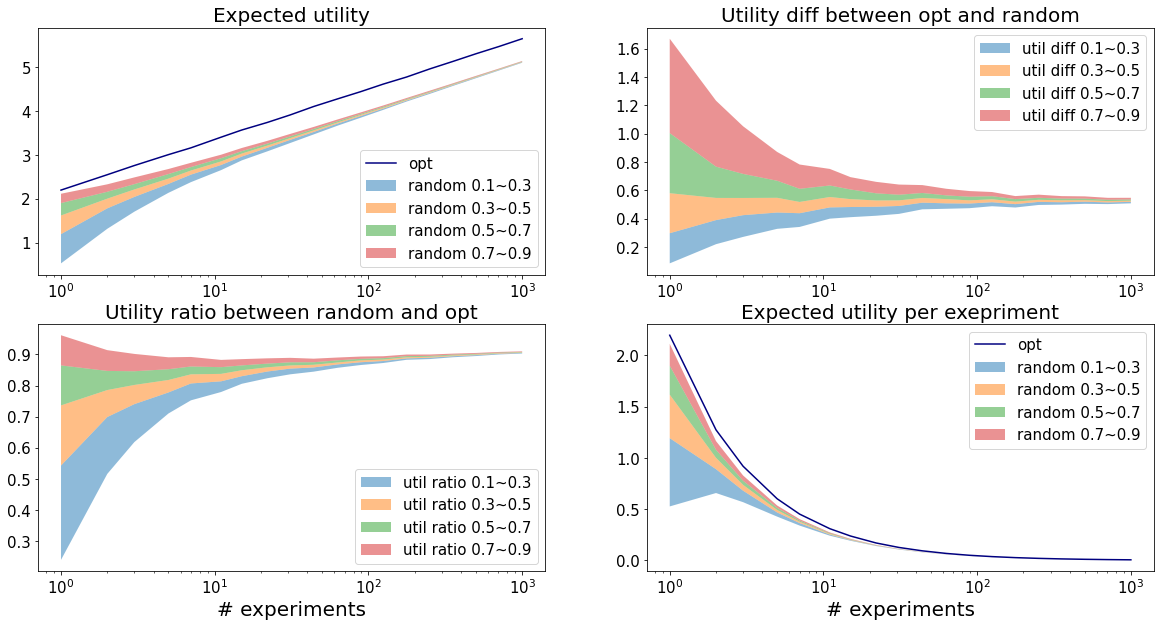

In [164]:
draw(n_stages, opt_utils, random_utils)

## $N_{\theta} = 2$

In [166]:
n_y = n_d = n_theta = 2
mu_prior = np.zeros(n_theta)
cov_prior = np.diag([9] * n_theta)
cov_noise = np.diag([1] * n_y)

In [167]:
# Get maximal expected utility over different n_stage
opt_utils = get_utils(n_stages, np.inf, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [00:05<00:00,  3.35it/s]


In [168]:
# Get random expected utilities over different n_stage
random_utils = get_utils(n_stages, 0, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [24:59<00:00, 78.94s/it] 


In [169]:
# np.save(f'random_vs_opt_Ntheta_equals_{n_theta}', {'opt_utils': opt_utils, 'random_utils': random_utils})

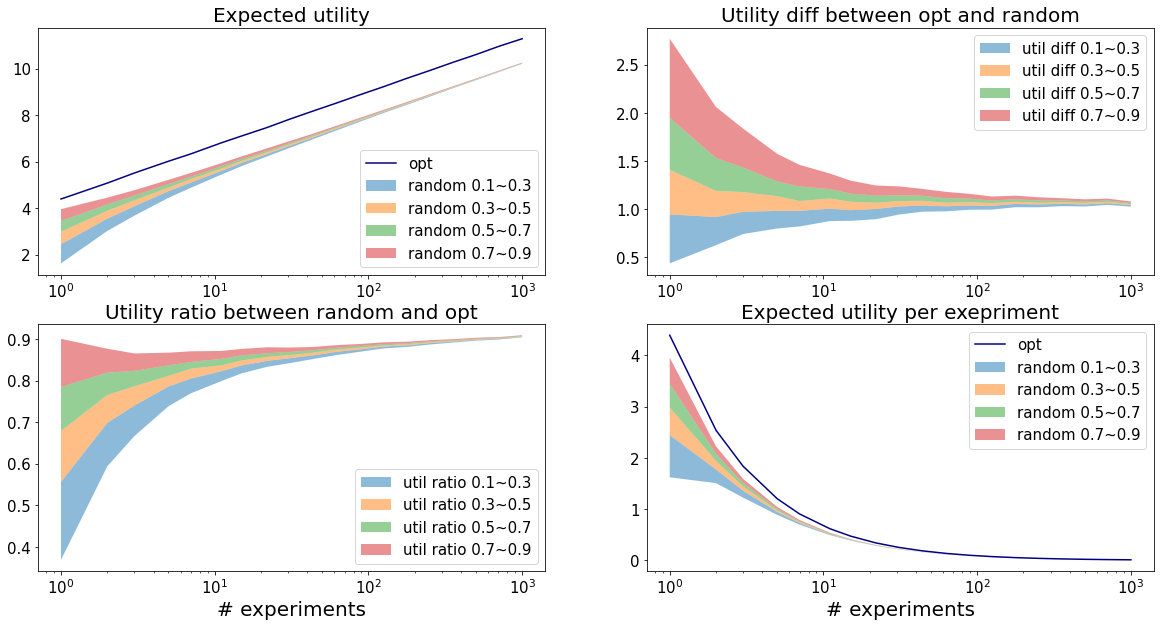

In [170]:
draw(n_stages, opt_utils, random_utils)

## $N_{\theta} = 3$

In [171]:
n_y = n_d = n_theta = 3
mu_prior = np.zeros(n_theta)
cov_prior = np.diag([9] * n_theta)
cov_noise = np.diag([1] * n_y)

In [172]:
# Get maximal expected utility over different n_stage
opt_utils = get_utils(n_stages, np.inf, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


In [173]:
# Get random expected utilities over different n_stage
random_utils = get_utils(n_stages, 0, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [39:26<00:00, 124.57s/it]


In [174]:
# np.save(f'random_vs_opt_Ntheta_equals_{n_theta}', {'opt_utils': opt_utils, 'random_utils': random_utils})

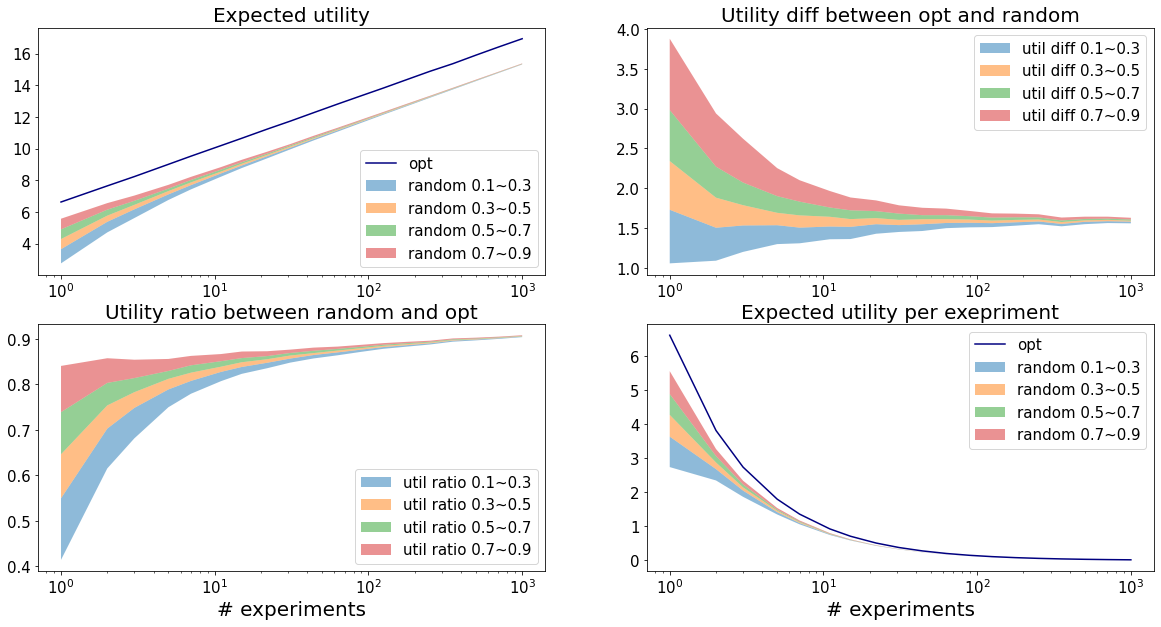

In [175]:
draw(n_stages, opt_utils, random_utils)

## $N_{\theta} = 5$

In [176]:
n_y = n_d = n_theta = 5
mu_prior = np.zeros(n_theta)
cov_prior = np.diag([9] * n_theta)
cov_noise = np.diag([1] * n_y)

In [177]:
# Get maximal expected utility over different n_stage
opt_utils = get_utils(n_stages, np.inf, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


In [178]:
# Get random expected utilities over different n_stage
random_utils = get_utils(n_stages, 0, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [1:08:00<00:00, 214.79s/it]


In [179]:
# np.save(f'random_vs_opt_Ntheta_equals_{n_theta}', {'opt_utils': opt_utils, 'random_utils': random_utils})

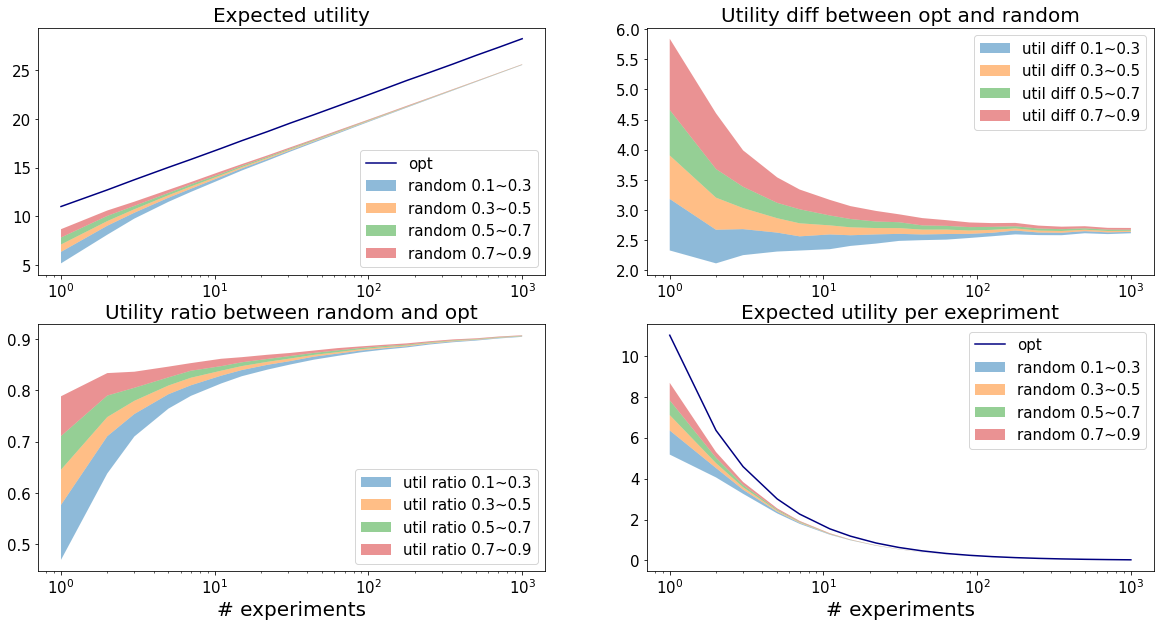

In [180]:
draw(n_stages, opt_utils, random_utils)

## $N_{\theta} = 10$

In [181]:
n_y = n_d = n_theta = 10
mu_prior = np.zeros(n_theta)
cov_prior = np.diag([9] * n_theta)
cov_noise = np.diag([1] * n_y)

In [182]:
# Get maximal expected utility over different n_stage
opt_utils = get_utils(n_stages, np.inf, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


In [183]:
# Get random expected utilities over different n_stage
random_utils = get_utils(n_stages, 0, mu_prior, cov_prior, cov_noise, n_y_sample, d_range)

100%|██████████| 19/19 [2:32:00<00:00, 480.03s/it] 


In [184]:
np.save(f'random_vs_opt_Ntheta_equals_{n_theta}', {'opt_utils': opt_utils, 'random_utils': random_utils})

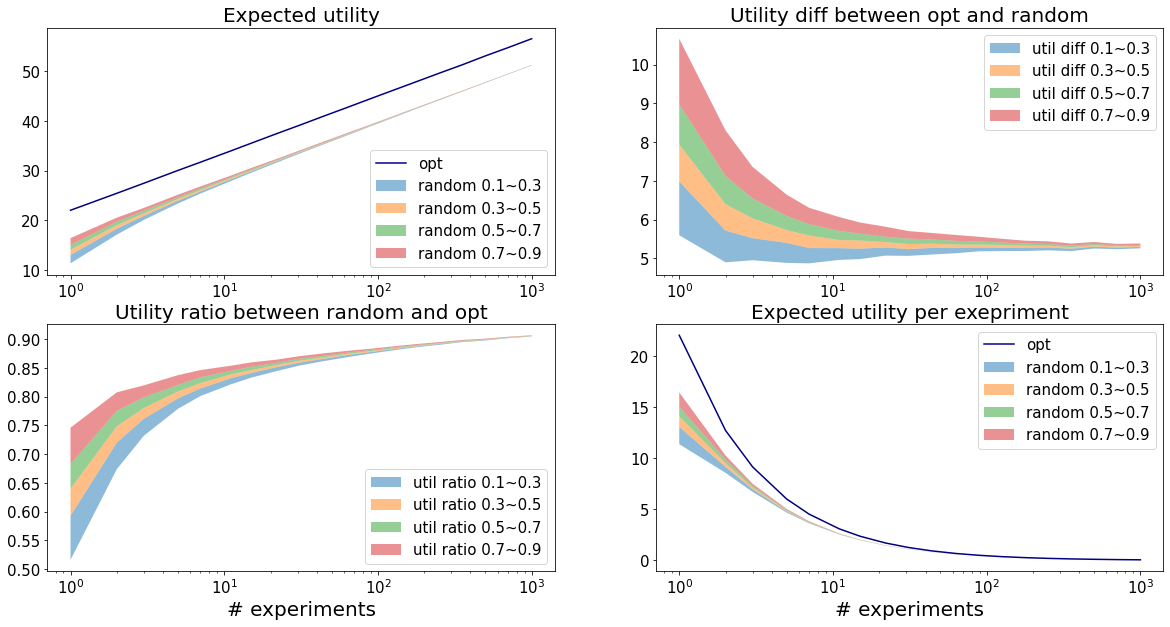

In [185]:
draw(n_stages, opt_utils, random_utils)